In [11]:
import fasttext
import json
from faq50_adapted import FAQ, extract_word_probs
from topic_word_probs import *
from tfidf_classifier import TFIDF_Classifier
from cs_lemmatizer import *


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
model_path = "models/cc.cs.300.bin"
model = fasttext.load_model(model_path)

### Tests:

In [18]:
path_to_q = "upv_faq/Q78_questions.xlsx"
path_to_a = "upv_faq/Q78_answers_no_tags.xlsx"

path_to_save = "780_upv_questions/w_probs_in_q_and_a.json"
probs, n_words = count_word_probs_in_corpuses(path_to_save, path_to_questions=path_to_q, path_to_answers=path_to_a)

# with open(path_to_save, "r") as wp_file:
#     probs = json.load(wp_file)

# print(dict(sorted(probs.items(), key=lambda item: -item[1])))

In [37]:
q_xslx = "upv_faq/Q78_questions.xlsx"
a_xslx = "upv_faq/Q78_answers.xlsx"

faq = FAQ(model, q_xslx, a_xslx, probs=probs, alpha=0.41, rm_stop_words=True, lemm=True)

In [38]:
acc, acc_sec = faq.cross_match_test()
print(f"\nQuestion Cross-Match Accuracy: 1st: {round(acc, 3)}, 2nd: {round(acc_sec, 3)}")

acc, acc_sec = faq.mean_match_test()
print(f"\nQuestion Mean-Match Accuracy: 1st: {round(acc, 3)}, 2nd: {round(acc_sec, 3)}")


Question Cross-Match Accuracy: 1st: 0.466, 2nd: 0.372

Question Mean-Match Accuracy: 1st: 0.671, 2nd: 0.132


### Mean match test without inclusion of tested question:

In [39]:
f, s, t = faq.mean_match_test_disjunctive()
print(f"\033[1m1st right: {f} \033[0m")
print(f"2nd right: {s}\n3rd right: {t}\n-> {round(f+s+t, 3)}")

1st right: 0.481 
2nd right: 0.135
3rd right: 0.065
-> 0.681


: 

{'být': 359.0, 'vzor': 229.0, 'průmyslový': 200.0, 'ochranný': 135.0, 'přihláška': 132.0, 'informace': 90.0, 'podat': 88.0, 'najít': 81.0, 'a': 68.0, 'při': 63.0, 'ochrana': 49.0, 'patentu': 47.0, 'možný': 45.0, 'služba': 43.0, 'vynález': 40.0, 'rešerše': 37.0, 'poplatek': 35.0, 'patent': 30.0, 'platnost': 28.0, 'právní': 27.0, 'z': 26.0, 'rešeršní': 26.0, 'užitných': 25.0, 'získat': 24.0, 'označený': 22.0, 'žádost': 22.0, 'nějaký': 21.0, 'poplatků': 21.0, 'podmínka': 19.0, 'proces': 19.0, 'zahraniční': 18.0, 'způsob': 17.0, 'muset': 16.0, 'zpracovat': 16.0, 'stan': 15.0, 'znamenat': 15.0, 'výmaz': 15.0, 'rešerši': 14.0, 'přihlášce': 13.0, 'doba': 13.0, 'přihlásit': 13.0, 'systém': 13.0, 'týkající': 12.0, 'všechen': 12.0, 'předmět': 12.0, 'dostupný': 12.0, 'poplatku': 12.0, 'správný': 12.0, 'elektronické': 12.0, 'symbol': 12.0, 'Věstníku': 11.0, 'provést': 11.0, 'potřeba': 11.0, 'rešeršních': 11.0, 'původ': 10.0, 'správní': 10.0, 'spisu': 10.0, 'zveřejnit': 10.0, 'zrušený': 10.0, 'reše

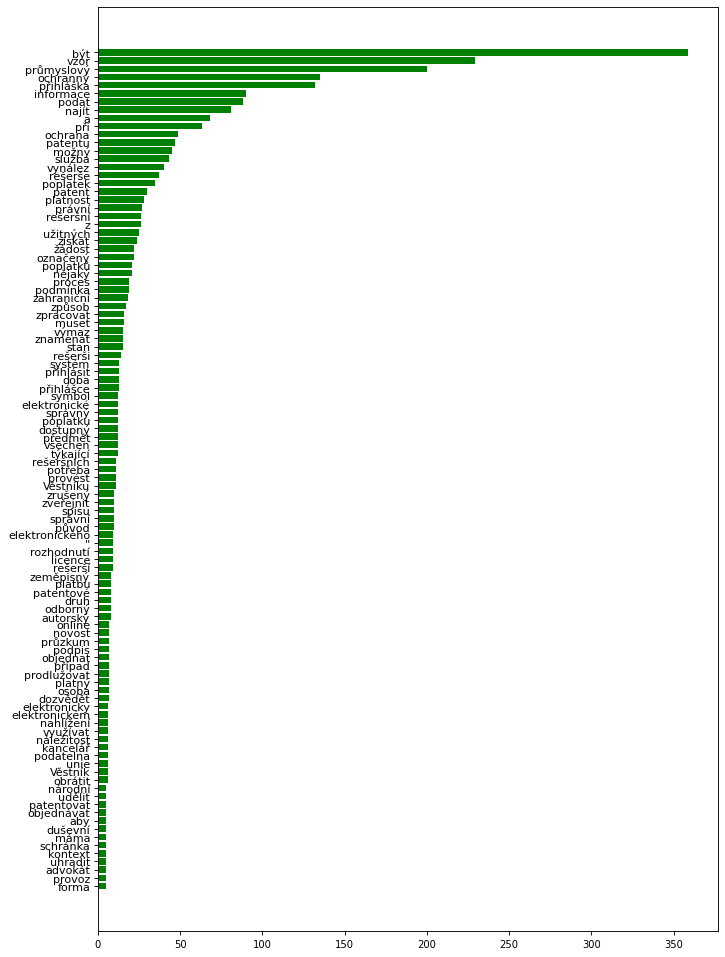

In [246]:
# pouze words from questions:
probs, n_words = count_word_probs_in_corpuses(path_to_save, path_to_questions=path_to_q, path_to_answers=None)
# histogram_of_words(probs, n_words)

In [76]:
LMTZR.remove_stop_words_from_sentence(["rešerše", "mezi", "jsem", "přihlasit", "jak", "patentem"])

['rešerše', 'přihlasit', 'patentem']

## Weighting with TF-IDF

In [181]:
path_to_q = "upv_faq/Q78_questions.xlsx"
path_to_a = "upv_faq/Q78_answers_no_tags.xlsx"

path_to_save = "780_upv_questions/w_probs_in_q_and_a.json"
# probs_old, n_words = count_word_probs_in_corpuses(path_to_save, path_to_questions=path_to_q, path_to_answers=None)

c = TFIDF_Classifier(path_to_q)
test_data = c.structure_data(test_data_percent=1) 
tfidf_matrix, feat_names = c.get_TFIDF_matrix()
probs = get_TFIDF_threshold_probabilities(tfidf_matrix, feat_names)

q_xslx = "upv_faq/Q78_questions.xlsx"
a_xslx = "upv_faq/Q78_answers.xlsx"

faq = FAQ(model, q_xslx, a_xslx, probs=probs, alpha=0.3, rm_stop_words=True, lemm=True)

0.17316466022690366
n words = 806
 "probs" from tf_idf: {'stížnost': 0.9311686063270178, 'autorský': 0.7907915225850033, 'licence': 0.7672268698044467, 'spisu': 0.7653411250424013, 'rozhodnutí': 0.7512331979193131, 'zahraničí': 0.7499572546768287, 'věstníku': 0.7124378616911251, 'námitka': 0.6918026696096419, 'užitného': 0.6565735082516224, 'rešerše': 0.6556532556201639, 'patentovat': 0.6535428766935597, 'platnost': 0.6269204573866282, 'řešení': 0.6202834923310422, 'výpis': 0.6197280124820415, 'předpis': 0.6116521438655397, 'průmyslový': 0.6067390800085124, 'výmaz': 0.5975677608827064, 'vzor': 0.5972611511080148, 'právo': 0.5947005605686688, 'užitných': 0.592942382734436, 'vynález': 0.5836051566911388, 'variabilní': 0.5681309232841942, 'zrušený': 0.5559775514312584, 'technický': 0.5558969731954814, 'třídící': 0.5545744190482382, 'ochranný': 0.5473125814336743, 'známka': 0.5473125814336743, 'výrobek': 0.5461540061391776, 'symbol': 0.5299741940416106, 'ověření': 0.526291855236298, 'mezin

In [182]:
""" prev best results:
0.471, 0.372 : alpha=0.23

1st right: 0.481 
2nd right: 0.135
3rd right: 0.065
-> 0.681 : alpha=0.41
"""

acc, acc_sec = faq.cross_match_test()
print(f"\nQuestion Cross-Match Accuracy: 1st: {round(acc, 3)}, 2nd: {round(acc_sec, 3)}")

f, s, t = faq.mean_match_test_disjunctive()
print(f"\n\033[1m1st right: {f} \033[0m")
print(f"2nd right: {s}\n3rd right: {t}\n-> {round(f+s+t, 3)}")


Question Cross-Match Accuracy: 1st: 0.565, 2nd: 0.484

1st right: 0.497 
2nd right: 0.145
3rd right: 0.069
-> 0.711


## Confused sentences:

In [8]:
# Ambiguous matches
path_to_save = "780_upv_questions/same_question_different_answers.json"
faq.get_same_question_different_answer_pairs(save_path=path_to_save)

Same question with different classes:

Q: Jaký je hlavní rozdíl mezi patentem a užitným vzorem? It's idx= 329 , true_class= 33
Q_argmax: Jaké jsou hlavní rozdíly mezi užitným vzorem a patentem? It's idx=  341 , true_class= 34

Q: Jaké jsou hlavní rozdíly mezi užitným vzorem a patentem? It's idx= 341 , true_class= 34
Q_argmax: Jaký je hlavní rozdíl mezi patentem a užitným vzorem? It's idx=  329 , true_class= 33

Q: Jaké jsou možnosti podání přihlášky průmyslového vzoru?  It's idx= 512 , true_class= 51
Q_argmax: Jaké jsou možnosti podání přihlášky průmyslového vzoru? It's idx=  490 , true_class= 49

Q: Kdo může podat přihlášku průmyslového vzoru? It's idx= 519 , true_class= 52
Q_argmax: Kdo může podat přihlášku průmyslového vzoru? It's idx=  492 , true_class= 49

Q: Jak mohu objednat rešeršní služby na Úřadu? It's idx= 550 , true_class= 55
Q_argmax: Jak mohu objednat rešeršní služby Úřadu? It's idx=  449 , true_class= 45

Q: Kdo může podat přihlášku užitného vzoru? It's idx= 592 , true_c

{'Jaký je hlavní rozdíl mezi patentem a užitným vzorem?': ['33', '34'],
 'Jaké jsou hlavní rozdíly mezi užitným vzorem a patentem?': ['34', '33'],
 'Jaké jsou možnosti podání přihlášky průmyslového vzoru? ': ['51', '49'],
 'Kdo může podat přihlášku průmyslového vzoru?': ['52', '49'],
 'Jak mohu objednat rešeršní služby na Úřadu?': ['55', '45'],
 'Kdo může podat přihlášku užitného vzoru?': ['59', '61'],
 'Jak mohu objednat rešeršní služby Úřadu?': ['65', '45'],
 'Jak dlouho trvá zpracování rešerše?': ['65', '45', '74'],
 'Co znamená kvalifikované zveřejnění technického řešení?': ['68', '58'],
 'Jakým způsobem lze podat objednávku na rešeršní službu?': ['74', '55']}

In [9]:
faq.get_most_confused_questions(cos_sim_threshold=0.85) # with mean-match

(788, 79)
(788,)
41     Na jaké stránce jsou uvedeny nejdůležitější pr...
399    Kde mohu najít právní předpisy týkající se pop...
400    Jaké jsou nejdůležitější právní předpisy týkaj...
Name: question, dtype: object


In [10]:
path_to_save = "780_upv_questions/most_missclassified_class_pairs"
faq.get_most_misclassified_class_pairs(n_of_common_misses=3, save_path=path_to_save)

(19, 45) 4
(26, 24) 3
(26, 25) 3
(30, 55) 4
(31, 69) 4
(33, 34) 4
(35, 65) 3
(36, 57) 5
(40, 4) 3
(42, 44) 3
(43, 51) 3
(43, 47) 3
(45, 55) 3
(49, 51) 5
(52, 51) 4
(53, 62) 4
(58, 68) 6
(65, 55) 3
(71, 51) 3
(77, 3) 5
['19:45', '26:24', '26:25', '30:55', '31:69', '33:34', '35:65', '36:57', '40:4', '42:44', '43:51', '43:47', '45:55', '49:51', '52:51', '53:62', '58:68', '65:55', '71:51', '77:3']


In [3]:
questions_xlsx = "780_upv_questions/expanded_data_all2.xlsx"
# questions_xlsx = "upv_faq/Q50_questions.xlsx"
c = TFIDF_Classifier(questions_xlsx)

In [4]:
test_data = c.structure_data(test_data_percent=0.1) 

c.get_TFIDF_matrix()

In [5]:
c.classify_sentence("Co by nastalo kdyby patent byl zrušen?")

73

In [6]:
c.classify_test_sentences_list(test_data)

Got right: 0.5128205128205128


In [7]:
test_data = c.structure_data(test_data_percent=1) # without removal from train data
c.get_TFIDF_matrix()
c.classify_test_sentences_list(test_data)

Got right: 0.7982233502538071


In [8]:
c.leave_one_out_test()

0it [00:00, ?it/s]

788it [01:00, 13.04it/s]


0.522